# Synthetic Image Interpolation
## Sam Potter
## Current: 2/27/19

## Path and Imports

In [1]:
# bootstrap $PATH
import sys
import os
sys.path.extend(['C:\\Users\\potterst1\\Desktop\Repositories\BitBucket\dic',
                 'C:/Users/potterst1/Desktop/Repositories/BitBucket/dic'])
sys.path.extend(['/workspace/stpotter/git/bitbucket/dic'])
import warnings
from dic import nurbs
from dic import fileIO
from dic import numerics
from dic import analysis
from dic import image_processing
from dic import utilities
import cv2
from matplotlib import pyplot as plt
import numpy as np
from geomdl import BSpline as bs
from geomdl import utilities as gutil
import scipy.optimize as sciopt
import scipy.signal as sig
from scipy.ndimage import sobel
import numba
from numba import jit

## Magics

In [2]:
%matplotlib inline

### Read in ref image file

In [3]:
# Read
# Hard code absolute paths for now. Fix later'
dic_name = 'C:\\Users\\potterst1\\Desktop\\Repositories\\BitBucket\\dic\\data\\DIC_S_cropped_gray_pad_0.tiff'
psfdi_name = 'C:\\Users\\potterst1\\Desktop\\Repositories\\BitBucket\\dic\\data\\DOA_cropped_gray_pad_0.tiff'
dic_name = '/workspace/stpotter/git/bitbucket/dic/data/DIC_S_cropped_gray_pad_0.tiff'
psfdi_name = '/workspace/stpotter/git/bitbucket/dic/data/DOSA_cropped_gray_pad_0.tiff'
def_image = cv2.imread(dic_name, -1)  # Read in image 'as is'

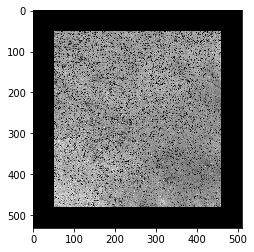

In [4]:
# Display
plt.imshow(def_image, cmap='gray')

In [5]:
dx = 0
dy = 0
F11 = 1.01
F12 = 0
F21 = 0
F22 = 1.0
F = np.array([[F11, F12],
              [F21, F22]])
Finv = np.linalg.inv(F)
F11i = Finv[0, 0]
F12i = Finv[0, 1]
F21i = Finv[1, 0]
F22i = Finv[1, 1]
warp = np.array([[F11i, F12i, -dx],
                 [F21i, F22i, -dy]])

In [6]:
# get def image interp coefficients
def_coeff = numerics.image_interp_bicubic(def_image)

In [7]:
# Create sub images (def)
def_sub_image = def_image[50:450, 50:450]

In [14]:
np.array([50, 50]) @ F

array([50.5, 50. ])

In [15]:
# Create ref sub image
ref_sub_image = np.zeros(def_sub_image.shape)
i = 0
j = 0
for row in range(50, 450):
    for col in range(50, 450):
        # New pt (x, y)
        pt = F @ np.array([col, row])
        val = numerics.eval_interp_bicubic(def_coeff, pt[0], pt[1], def_image.shape)
        ref_sub_image[i, j] = val
        j+=1
    j=0
    i+=1        

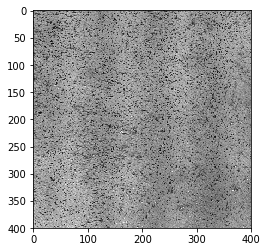

In [16]:
plt.imshow(ref_sub_image, cmap='gray')

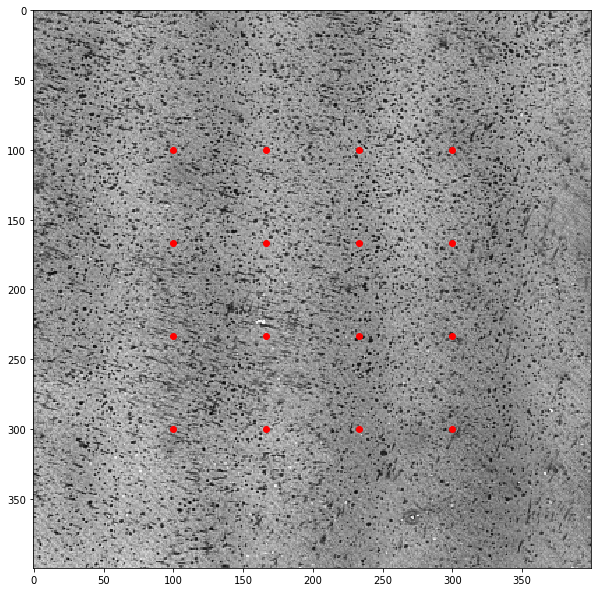

In [17]:
# Specify region of interest
# Format: [column index for start of X, column index for end of X, row index for start of Y, row index for end of Y]
subregion_indices = np.array([100, 300, 100, 300])

# Control Points
rowmin_index = subregion_indices[-2:].min()
rowmax_index = subregion_indices[-2:].max()
colmin_index = subregion_indices[:2].min()
colmax_index = subregion_indices[:2].max()
x = np.linspace(colmin_index, colmax_index, 4)
y = np.linspace(rowmin_index, rowmax_index, 4)
coords = np.zeros((len(x) * len(y), 2))
k = 0
for i in range(0, len(x)):
    for j in range(0, len(y)):
        coords[k, :] = np.array([x[i], y[j]])
        k += 1

# Surface
ref_surf = bs.Surface()

ref_surf.degree_u = 3
ref_surf.degree_v = 3

num_ctrlpts = np.sqrt(len(coords)).astype('int')

ref_surf.set_ctrlpts(coords.tolist(), num_ctrlpts, num_ctrlpts)

ref_surf.knotvector_u = gutil.generate_knot_vector(ref_surf.degree_u, num_ctrlpts)
ref_surf.knotvector_v = gutil.generate_knot_vector(ref_surf.degree_v, num_ctrlpts)

ref_surf.delta = 0.01

#TODO: MAKE THIS A FUNCTION
# Compute ROI and ROI uv values
# Get min and max column values from min/max reference ctrlpt node x values
min_col_index = np.min(coords[:, 0]).astype('int')
max_col_index = np.max(coords[:, 0]).astype('int')

# Get maximum column number for sub image array from ref ctrlpt node x values
colmax = (np.max(coords[:, 0]) - np.min(coords[:, 0])).astype('int')

# Get min and max column values from min/max reference ctrlpt node x values
min_row_index = np.min(coords[:, 1]).astype('int')
max_row_index = np.max(coords[:, 1]).astype('int')

# Get min and max row values from min/max reference ctrlpt node y values
rowmax = (np.max(coords[:, 1]) - np.min(coords[:, 1])).astype('int')

# Set reference image mesh over image
roi = ref_sub_image[min_row_index:max_row_index, min_col_index:max_col_index]

uv_vals = np.zeros((2, )+ roi.shape)
for i in range(0, rowmax):
    for j in range(0, colmax):
        uv_vals[0, i, j] = j / colmax
        uv_vals[1, i, j] = i / rowmax

#TODO: Up to here

# Get interpolation coefficients
ref_coeff = numerics.image_interp_bicubic(ref_sub_image)
def_coeff = numerics.image_interp_bicubic(def_image)

# Plot image with reference mesh nodes
x = coords[:, 0]
y = coords[:, 1]
fig, ax = plt.subplots(figsize=(10, 20))
ax.imshow(ref_sub_image, cmap='gray')
ax.plot(x, y, 'o', color='red')
plt.show()

In [18]:
# Test synthetically deformed control points
synth_coords = np.zeros((len(coords), 2))
for i in range(len(synth_coords)):
    synth_coords[i, :] = np.matmul(F, coords[i, :]) + np.array([dx, dy])

# Compute synthetic control point displacements
synth_coords_disp = synth_coords - coords

# Compute znssd between synthetic and ref coordinates
synth_znssd = analysis.mesh_znssd_bicubic(roi, ref_sub_image.shape, def_sub_image.shape, ref_surf, uv_vals, ref_coeff,
                                          def_coeff, synth_coords_disp)

In [19]:
synth_znssd

82204.82368814044